In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx 
import optax

import numpy as np
import matplotlib.pyplot as plt
import gstools as gs

In [2]:
def Matrix(D: float, dx: float, dt: float, size: int):

    LAMBDA = (D * dt) / dx**2
    GAMMA_1 = 1 + (-1 * dt) / 2 + LAMBDA 
    GAMMA_2 = 1 - (-1 * dt) / 2 - LAMBDA 

    A = np.zeros((size, size))
    B = np.zeros((size, size))

    for i in range(1, size-1):
        A[i,i] = GAMMA_1
        A[i,i+1] = -LAMBDA / 2
        A[i,i-1] = -LAMBDA / 2

        B[i,i]  = GAMMA_2
        B[i,i+1] = LAMBDA / 2
        B[i,i-1] = LAMBDA / 2


    A[0, 0] = - 3 / (4 * dx)
    A[0, 1] = 1 / dx
    A[0, 2] = -1 / (4 * dx)

    A[-1, -1] = 3 / (4 * dx)
    A[-1, -2] = -1 / dx
    A[-1, -3] = 1 / (4 * dx)

    B[0, 0] = 3 / (4 * dx)
    B[0, 1] = -1 / dx
    B[0, 2] = 1 / (4 * dx)

    B[-1, -1] = -3 / (4 * dx)
    B[-1, -2] = 1 / dx
    B[-1, -3] = -1 / (4 * dx)

    return A, B

def Solve(D, x, t, initial_condition, println, step = 1):

    X = x
    T = t
    X_K = initial_condition

    A, B = Matrix(D, X[1], T[1], len(x))
    E = B @ X_K
    return jnp.linalg.solve(A, E)



An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


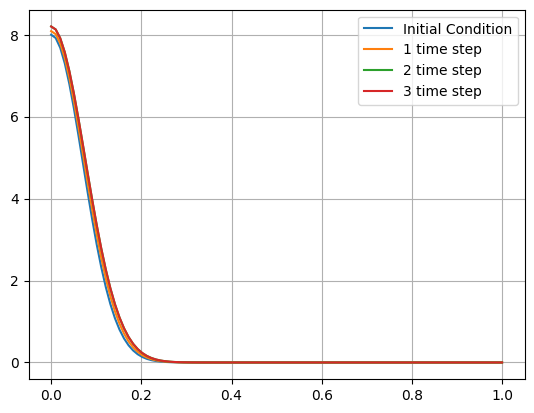

In [3]:
# PARAMETROS DO MODELO
D = 0.0039
P = 0.0453
C0 = 8e3

# DOMINIO DO MODELO
L = 2
TF = 80

# QUANTIDADE DE NÓS DO DOMÍNIO
N_X = 100
N_T = TF

# VARIAVEIS E CONDIÇÃO INICIAL
X = jnp.linspace(0, 1, N_X, dtype = jnp.float32) 
T = jnp.linspace(0, TF * P, N_T, dtype = jnp.float32) 

# CONDIÇÃO INICIAL
IC = L**3 * jnp.exp(-100 * X**2)

# SOLUÇÃO CRANK - NICOLSON
SOLUTION = Solve(D, X, T, IC, False, 40)
SOLUTION2 = Solve(D, X, T, SOLUTION, False, 40)
SOLUTION3 = Solve(D, X, T, SOLUTION2, False, 40)

# PLOTAGEM
plt.plot(X, IC, label = 'Initial Condition')
plt.plot(X, SOLUTION, label = '1 time step')
plt.plot(X, SOLUTION2, label = '2 time step')
plt.plot(X, SOLUTION2, label = '3 time step')
plt.grid()
plt.legend()
plt.show()

In [4]:
#PROCESSO GAUSSIANO
seed = gs.random.MasterRNG(123)
def Random_functions(x):
    model = gs.Gaussian(dim=1, var=20, len_scale=0.6)
    srf= gs.SRF(model, seed=seed())
    f = srf.structured([x])
    return f

#CONDIÇÕES INICIAIS ALEATÓRIAS VIA PROCESSO GAUSSIANO
N_ICS = 500
ICS = np.zeros((N_ICS, N_X))
for fn in range(N_ICS):
    x_values = Random_functions(X)
    ICS[fn, :] = x_values

# GERANDO SOLUÇÕES FDM PARA CADA CONDIÇÃO INICIAL

TARGET = []
for i in ICS:
    TARGET.append(Solve(D, X, T, i, False, 40))

TARGET = jnp.array(TARGET)
TARGET.shape, ICS.shape

((500, 100), (500, 100))

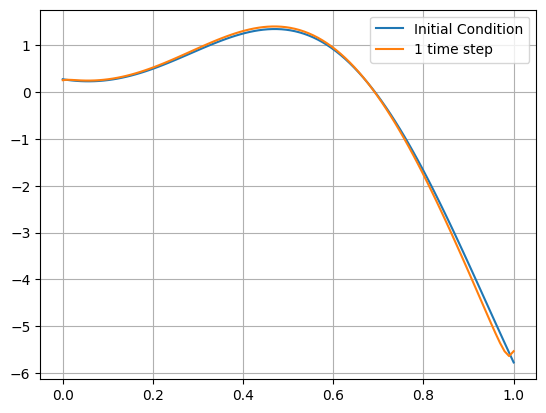

In [5]:
# PLOTAGEM SOLUÇÕES COM CONDIÇÕES INICIAIS ALEATÓRIAS
i = 30
plt.plot(X, ICS[i], label = 'Initial Condition')
plt.plot(X, TARGET[i], label = '1 time step')
plt.grid()
plt.legend()
plt.show()

In [6]:
# OBTENÇÃO DO INPUT TRUNK
TRUNK = []
for i in X:
    TRUNK.append([i])
TRUNK = jnp.array(TRUNK)

# OBTENÇÃO DO INPUT BRANCH
BRANCH = ICS 

# SHAPE DA BASE DE DADOS
BRANCH.shape, TRUNK.shape, TARGET.shape

((500, 100), (100, 1), (500, 100))

In [7]:
# ARQUITETURA DA REDE DEEPONET

class DeepONet(eqx.Module):

    branch__net: eqx.nn.MLP
    trunk__net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
            self,
            input_branch,
            neurons,
            num_layers,
            interact_size,
            activation,
            *,
            key
    ):
        
        b_key, t_key = jr.split(key)
        self.branch__net = eqx.nn.MLP(
            in_size = input_branch,
            out_size = interact_size,
            width_size = neurons,
            depth = num_layers,
            activation = activation,
            key = b_key,
        )
        self.trunk__net = eqx.nn.MLP(
            in_size = 1,
            out_size = interact_size,
            width_size = neurons,
            depth = num_layers,
            activation = activation,
            key = t_key,
        )
        self.bias = jnp.zeros((1,))

    def __call__(
            self,
            x_branch,
            x_trunk
    ):
        out_b = self.branch__net(x_branch)
        out_t = self.trunk__net(x_trunk)
        inner_prod = jnp.sum(out_b * out_t, keepdims=True)

        return (inner_prod + self.bias)[0]
    

In [8]:
model = DeepONet(
    input_branch = N_X,
    neurons = 180,
    num_layers = 4,
    interact_size = 40,
    activation = jax.nn.relu,
    key = jr.PRNGKey(0),
)

optim = optax.adam(1e-3)
state = optim.init(
    eqx.filter(model, eqx.is_array)
)

def loss_fn(model):

    pred = jax.vmap(
        jax.vmap(
            model,
            in_axes=(None, 0)
        ),
        in_axes=(0, None)
    )(BRANCH, TRUNK)

    mse = jnp.mean(jnp.square(pred - TARGET))
    return mse

@eqx.filter_jit
def update_fn(model, state):

    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_states = optim.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)

    return new_model, new_states, loss

loss_history = []
epochs = 50000

for ep in range(epochs):

    model, state, loss = update_fn(
        model,
        state,
    )
    loss_history.append(loss)

    if ep % 1000 == 0: 
        print(f'Iteration: {ep}/{epochs}    Loss: {loss}')     

    if loss < 1e-5: break    

print(f'\n\nErro Obtido: {loss}')

Iteration: 0/50000    Loss: 21.506031036376953
Iteration: 1000/50000    Loss: 0.06732375174760818
Iteration: 2000/50000    Loss: 0.009812855161726475
Iteration: 3000/50000    Loss: 0.015193178318440914
Iteration: 4000/50000    Loss: 0.004090850707143545
Iteration: 5000/50000    Loss: 0.0073707750998437405
Iteration: 6000/50000    Loss: 0.00040526234079152346
Iteration: 7000/50000    Loss: 0.0005085031734779477
Iteration: 8000/50000    Loss: 0.012343055568635464
Iteration: 9000/50000    Loss: 0.000358534452971071
Iteration: 10000/50000    Loss: 0.00025244257994927466
Iteration: 11000/50000    Loss: 0.0003626306133810431
Iteration: 12000/50000    Loss: 0.001119786174967885
Iteration: 13000/50000    Loss: 0.0004504274984356016
Iteration: 14000/50000    Loss: 0.0002702781348489225
Iteration: 15000/50000    Loss: 0.0004767503123730421
Iteration: 16000/50000    Loss: 0.00021679772180505097
Iteration: 17000/50000    Loss: 0.0003670560254249722
Iteration: 18000/50000    Loss: 0.000242591675487

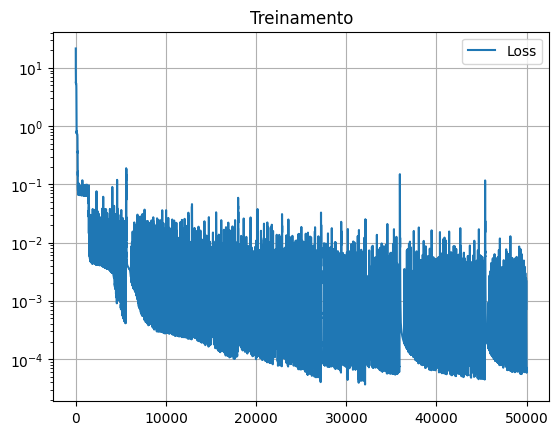

In [26]:
plt.plot(loss_history, label = 'Loss')
plt.grid()
plt.yscale('log')
plt.legend()
plt.title('Treinamento')
plt.show()   

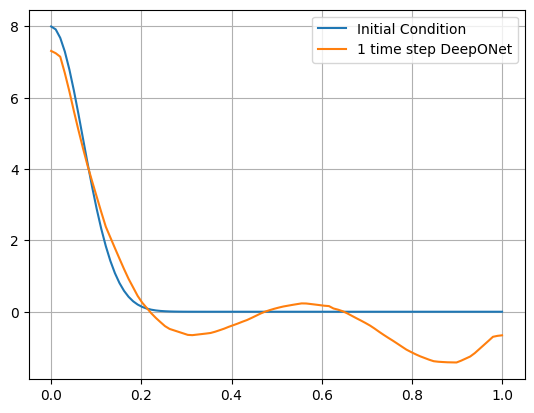

In [27]:
IC = L**3 * jnp.exp(-100 * X**2)
S = jax.vmap(model, in_axes=(None, 0))(IC, TRUNK)

plt.plot(X, IC, label = 'Initial Condition')
plt.plot(X, S, label = '1 time step DeepONet')
#plt.plot(X, SOLUTION, label = '1 time step FDM')
plt.grid()
plt.legend()
plt.show()

In [28]:
IC_DON = L**3 * jnp.exp(-100 * X**2)

DON = []
for it in range(N_T):

    S_DON = jax.vmap(model, in_axes=(None, 0))(IC_DON, TRUNK)
    DON.append(S_DON)
    IC_DON = S_DON.copy()

DON = jnp.array(DON)

In [29]:
IC_FDM = L**3 * jnp.exp(-100 * X**2)

FDM = []
for it in range(N_T):

    S_FDM = Solve(D, X, T, IC_FDM, False, 40)
    FDM.append(S_FDM)
    IC_FDM = S_FDM.copy()

FDM = jnp.array(FDM)

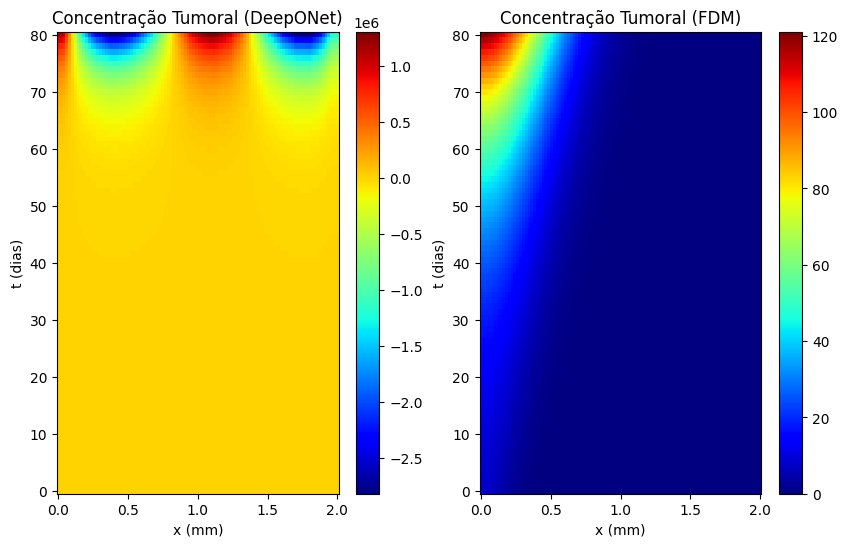

In [30]:
figure, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize = (10, 6))
plot1 = ax1.pcolormesh(X * L, T / P, DON, cmap = 'jet')
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('t (dias)')
ax1.set_title('Concentração Tumoral (DeepONet)')
plot2 = ax2.pcolormesh(X * L, T / P, FDM, cmap = 'jet')
ax2.set_xlabel('x (mm)')
ax2.set_ylabel('t (dias)')
ax2.set_title('Concentração Tumoral (FDM)')

plt.colorbar(plot1)
plt.colorbar(plot2)
plt.show()

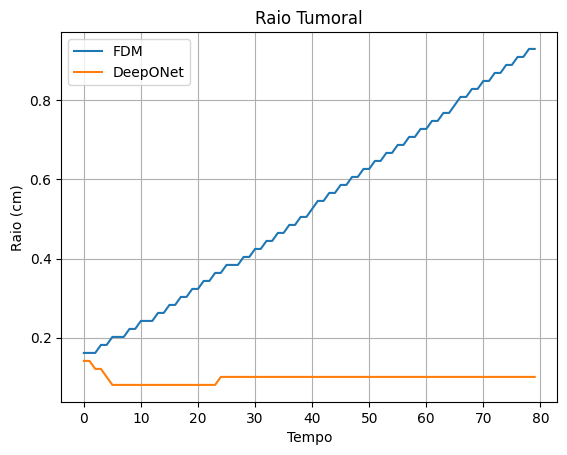

In [31]:
def Tumor_radius(s, x, size_x, size_t):
    
    R = np.zeros(size_t)

    for j in range(size_t):
        
        for i in range(size_x):

            if s[j, i] <= C0 * 0.6126 and i > 3:
                R[j] = x[i] * L
                break
    return R

raio_fdm = Tumor_radius(FDM * C0 / L**3, X, N_X, N_T)
raio_don = Tumor_radius(DON * C0 / L**3, X, N_X, N_T)

plt.plot(raio_fdm, label = 'FDM')
plt.plot(raio_don, label = 'DeepONet')
plt.title('Raio Tumoral')
plt.xlabel('Tempo')
plt.ylabel('Raio (cm)')
plt.legend()
plt.grid()


In [32]:
ALPHA = 0.0305
AB = 10

def R(d: float):
    return (1. - np.exp(-ALPHA * (d + (d**2 / AB)))) / P

DAYS = [
    [],
    [0, 1],
    [i for i in range(6)], 
    [i for i in range(21)],
    [i for i in range(28)],
    [i for i in range(35)]
]
DOSES = [
    [],
    [60.0, 4.2],
    [12.2, 12.2, 12.2, 12.2, 12.2, 3.2],
    [2.8, 2.8, 2.8, 2.8, 2.8, 0.0, 0.0, 3.5, 3.5, 3.5, 3.5, 3.5, 0.0, 0.0, 6.5, 6.5, 6.5, 6.5, 6.5, 0.0, 0.0],
    [2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.9, 2.9, 2.9, 2.9, 2.9, 0.0, 0.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0],
    [1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0, 1.8, 1.8, 1.8, 1.8, 1.8, 0.0, 0.0]
]

def tratamento(days, doses):

    IC_DON = L**3 * jnp.exp(-100 * X**2)

    DON = []
    for it in range(N_T):

        if it in days:
            index = days.index(it)
            S = jax.vmap(model, in_axes=(None, 0))(IC_DON, TRUNK)
            S_DON = S - R(doses[index]) * S
            DON.append(S_DON)
            IC_DON = S_DON.copy()

        else:
            S_DON = jax.vmap(model, in_axes=(None, 0))(IC_DON, TRUNK)
            DON.append(S_DON)
            IC_DON = S_DON.copy()

    DON = jnp.array(DON)
    return DON

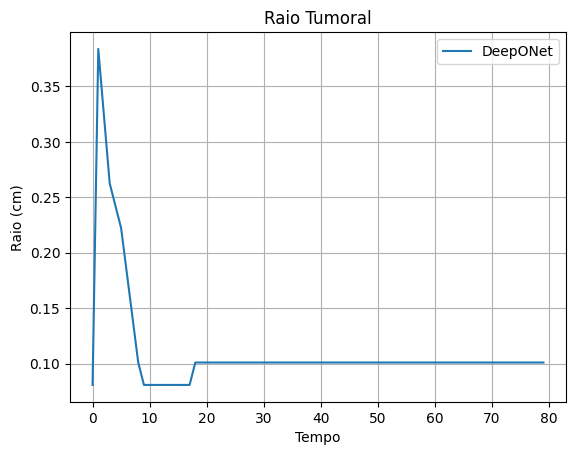

In [33]:
i = 1

DON = tratamento(DAYS[i], DOSES[i])
RAIO = Tumor_radius(DON * C0 / L**3, X, N_X, N_T)

plt.plot(RAIO, label = 'DeepONet')
plt.title('Raio Tumoral')
plt.xlabel('Tempo')
plt.ylabel('Raio (cm)')
plt.legend()
plt.grid()